Scenario Setup
Battery Specifications :
Initial SoC (soc_initial): 80% (0.8)
Capacity: 100 Ah
Internal Resistance (r_int): 0.05 Ohms
Process Noise Covariance (Q): 1×10^−4
 
Measurement Noise Covariance (R): 1×10^−1
 
Simulation Parameters :
Discharge Current: 5 A (constant)
Time Step (dt): 1 hour per step
Measured Voltage: Simulated based on the OCV model and internal resistance.

In [5]:
import numpy as np

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.10  # Estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Simplified linear OCV model: OCV = 3.5 + 0.5 * SoC
        return 3.5 + 0.5 * soc

    def predict(self, current, dt):
        # State prediction (Coulomb counting)
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))  # Clamp SoC
        # Update error covariance
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        # Measurement prediction
        v_pred = self.ocv(self.soc)- current * self.r_int
        # Innovation (measurement residual)
        y = voltage_measured - v_pred
        # Innovation covariance
        S = self.P * 0.5**2 + self.R  # 0.5 is d(OCV)/d(SoC)
        # Kalman gain
        K = self.P * 0.5 / S
        # Update state
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        # Update error covariance
        self.P = (1 - K * 0.5) * self.P

# Example usage
kf = KalmanFilterSoC(
    soc_initial=0.8,       # Initial SoC = 80%
    capacity=100,          # Battery capacity = 100 Ah
    r_int=0.05,            # Internal resistance = 0.05 Ohms
    process_noise=1e-4,    # Process noise covariance
    measurement_noise=1e-1 # Measurement noise covariance
)
current = 5  # 5A discharge
dt = 1  # 1 hour
voltage_measured = 3.75  # Measured voltage

kf.predict(current, dt)
print(f"Predicted SoC: {kf.soc * 100:.1f}%")
kf.update(voltage_measured, current)
print(f"Updated SoC: {kf.soc * 100:.1f}%")

Predicted SoC: 75.0%
Updated SoC: 80.0%


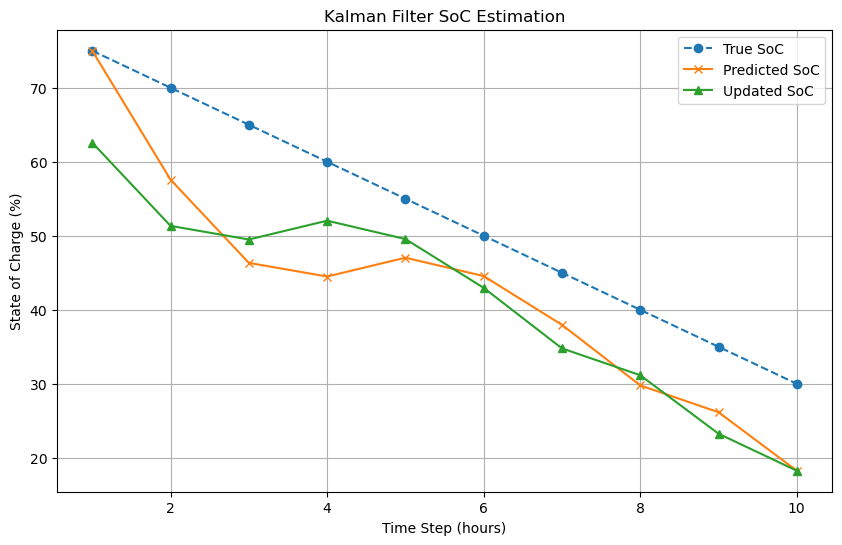

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.10  # Estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Simplified linear OCV model: OCV = 3.5 + 0.5 * SoC
        return 3.5 + 0.5 * soc

    def predict(self, current, dt):
        # State prediction (Coulomb counting)
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))  # Clamp SoC
        # Update error covariance
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        # Measurement prediction
        v_pred = self.ocv(self.soc) - current * self.r_int
        # Innovation (measurement residual)
        y = voltage_measured - v_pred
        # Innovation covariance
        S = self.P * 0.5**2 + self.R  # 0.5 is d(OCV)/d(SoC)
        # Kalman gain
        K = self.P * 0.5 / S
        # Update state
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        # Update error covariance
        self.P = (1 - K * 0.5) * self.P


# Simulation and Visualization
def simulate_and_visualize():
    # Initialize Kalman Filter
    kf = KalmanFilterSoC(
        soc_initial=0.8,       # Initial SoC = 80%
        capacity=100,          # Battery capacity = 100 Ah
        r_int=0.05,            # Internal resistance = 0.05 Ohms
        process_noise=1e-4,    # Process noise covariance
        measurement_noise=1e-1 # Measurement noise covariance
    )

    # Simulation parameters
    current = 5  # Constant discharge current (5 A)
    dt = 1      # Time step (1 hour)
    true_soc = 0.8  # True SoC starts at 80%

    # Lists to store results for plotting
    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []

    # Simulate over 10 hours
    for t in range(10):
        # True SoC decreases due to current draw
        true_soc -= (current * dt) / kf.capacity
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate measured voltage based on true SoC
        ocv_true = kf.ocv(true_soc)  # True OCV from the model
        voltage_measured = ocv_true - current * kf.r_int  # Add IR drop
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))  # Add measurement noise

        # Prediction step
        kf.predict(current=current, dt=dt)
        predicted_soc = kf.soc

        # Update step
        kf.update(voltage_measured=voltage_measured, current=current)
        updated_soc = kf.soc

        # Store results for plotting
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)  # Convert to percentage
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, true_socs, label="True SoC", linestyle="--", marker="o")
    plt.plot(time_steps, predicted_socs, label="Predicted SoC", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Updated SoC", linestyle="-", marker="^")
    plt.title("Kalman Filter SoC Estimation")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Run the simulation and visualization
simulate_and_visualize()

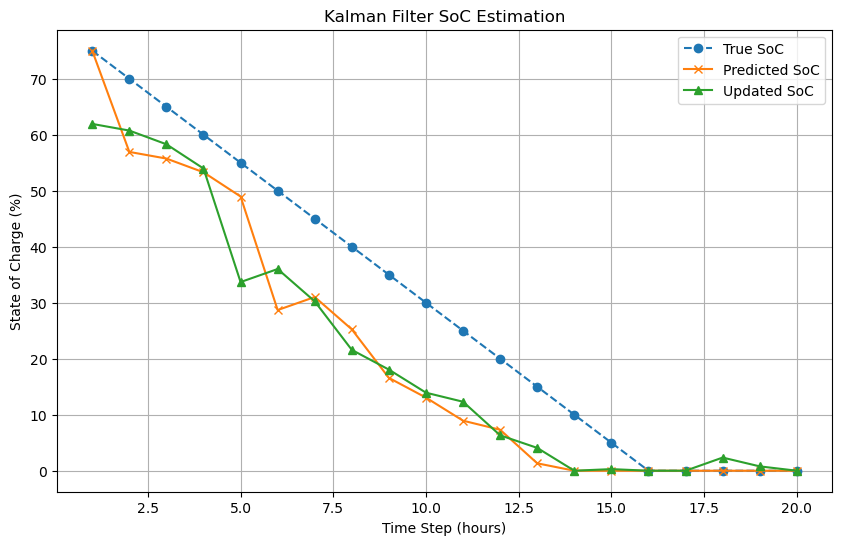

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.10  # Estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Nonlinear OCV model: OCV = 3.6 + 0.4 * SoC - 0.1 * SoC^2
        return 3.6 + 0.4 * soc - 0.1 * soc**2

    def predict(self, current, dt):
        # State prediction (Coulomb counting)
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))  # Clamp SoC
        # Update error covariance
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        # Measurement prediction
        v_pred = self.ocv(self.soc) - current * self.r_int
        # Innovation (measurement residual)
        y = voltage_measured - v_pred
        # Innovation covariance
        d_ocv_d_soc = 0.4 - 0.2 * self.soc  # Derivative of OCV w.r.t. SoC
        S = self.P * d_ocv_d_soc**2 + self.R
        # Kalman gain
        K = self.P * d_ocv_d_soc / S
        # Update state
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        # Update error covariance
        self.P = (1 - K * d_ocv_d_soc) * self.P


# Simulation and Visualization
def simulate_and_visualize():
    # Initialize Kalman Filter
    kf = KalmanFilterSoC(
        soc_initial=0.8,       # Initial SoC = 80%
        capacity=100,          # Battery capacity = 100 Ah
        r_int=0.05,            # Internal resistance = 0.05 Ohms
        process_noise=1e-4,    # Process noise covariance
        measurement_noise=1e-2 # Measurement noise covariance (reduced for better performance)
    )

    # Simulation parameters
    current = 5  # Constant discharge current (5 A)
    dt = 1      # Time step (1 hour)
    true_soc = 0.8  # True SoC starts at 80%

    # Lists to store results for plotting
    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []

    # Simulate over 20 hours
    for t in range(20):
        # True SoC decreases due to current draw
        true_soc -= (current * dt) / kf.capacity
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate measured voltage based on true SoC
        ocv_true = kf.ocv(true_soc)  # True OCV from the model
        voltage_measured = ocv_true - current * kf.r_int  # Add IR drop
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))  # Add measurement noise

        # Prediction step
        kf.predict(current=current, dt=dt)
        predicted_soc = kf.soc

        # Update step
        kf.update(voltage_measured=voltage_measured, current=current)
        updated_soc = kf.soc

        # Store results for plotting
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)  # Convert to percentage
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, true_socs, label="True SoC", linestyle="--", marker="o")
    plt.plot(time_steps, predicted_socs, label="Predicted SoC", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Updated SoC", linestyle="-", marker="^")
    plt.title("Kalman Filter SoC Estimation")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Run the simulation and visualization
simulate_and_visualize()

Mean Absolute Error (Predicted SoC): 6.27%
Mean Absolute Error (Updated SoC): 6.74%


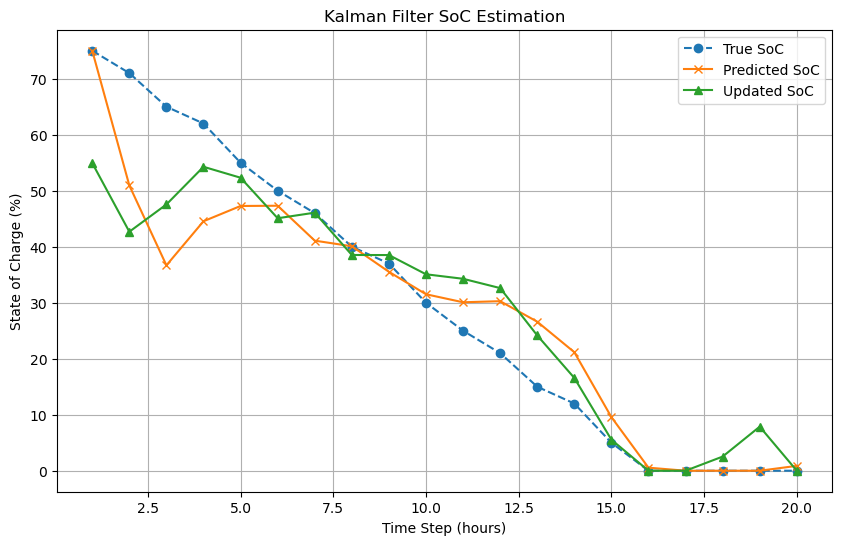

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.10  # Estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Nonlinear OCV model: OCV = 3.6 + 0.4 * SoC - 0.1 * SoC^2
        return 3.6 + 0.4 * soc - 0.1 * soc**2

    def predict(self, current, dt):
        # State prediction (Coulomb counting)
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))  # Clamp SoC
        # Update error covariance
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        # Measurement prediction
        v_pred = self.ocv(self.soc) - current * self.r_int
        # Innovation (measurement residual)
        y = voltage_measured - v_pred
        # Innovation covariance
        d_ocv_d_soc = 0.4 - 0.2 * self.soc  # Derivative of OCV w.r.t. SoC
        S = self.P * d_ocv_d_soc**2 + self.R
        # Kalman gain
        K = self.P * d_ocv_d_soc / S
        # Update state
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        # Update error covariance
        self.P = (1 - K * d_ocv_d_soc) * self.P


# Simulation and Visualization
def simulate_and_visualize():
    # Initialize Kalman Filter
    kf = KalmanFilterSoC(
        soc_initial=0.8,       # Initial SoC = 80%
        capacity=100,          # Battery capacity = 100 Ah
        r_int=0.05,            # Internal resistance = 0.05 Ohms
        process_noise=1e-3,    # Process noise covariance (increased)
        measurement_noise=5e-3 # Measurement noise covariance (reduced)
    )

    # Simulation parameters
    current_profile = [5, 4, 6, 3, 7, 5, 4, 6, 3, 7, 5, 4, 6, 3, 7, 5, 4, 6, 3, 7]  # Varying current
    dt = 1      # Time step (1 hour)
    true_soc = 0.8  # True SoC starts at 80%

    # Lists to store results for plotting
    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []

    # Simulate over 20 hours
    for t in range(20):
        current = current_profile[t]  # Varying current

        # True SoC decreases due to current draw
        true_soc -= (current * dt) / kf.capacity
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate measured voltage based on true SoC
        ocv_true = kf.ocv(true_soc)  # True OCV from the model
        voltage_measured = ocv_true - current * kf.r_int  # Add IR drop
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))  # Add measurement noise

        # Prediction step
        kf.predict(current=current, dt=dt)
        predicted_soc = kf.soc

        # Update step
        kf.update(voltage_measured=voltage_measured, current=current)
        updated_soc = kf.soc

        # Store results for plotting
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)  # Convert to percentage
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)

    # Calculate error metrics
    mae_predicted = np.mean(np.abs(np.array(predicted_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (Predicted SoC): {mae_predicted:.2f}%")
    print(f"Mean Absolute Error (Updated SoC): {mae_updated:.2f}%")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, true_socs, label="True SoC", linestyle="--", marker="o")
    plt.plot(time_steps, predicted_socs, label="Predicted SoC", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Updated SoC", linestyle="-", marker="^")
    plt.title("Kalman Filter SoC Estimation")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Run the simulation and visualization
simulate_and_visualize()

Mean Absolute Error (Coulomb Counting): 0.00%
Mean Absolute Error (Kalman Filter): 7.08%


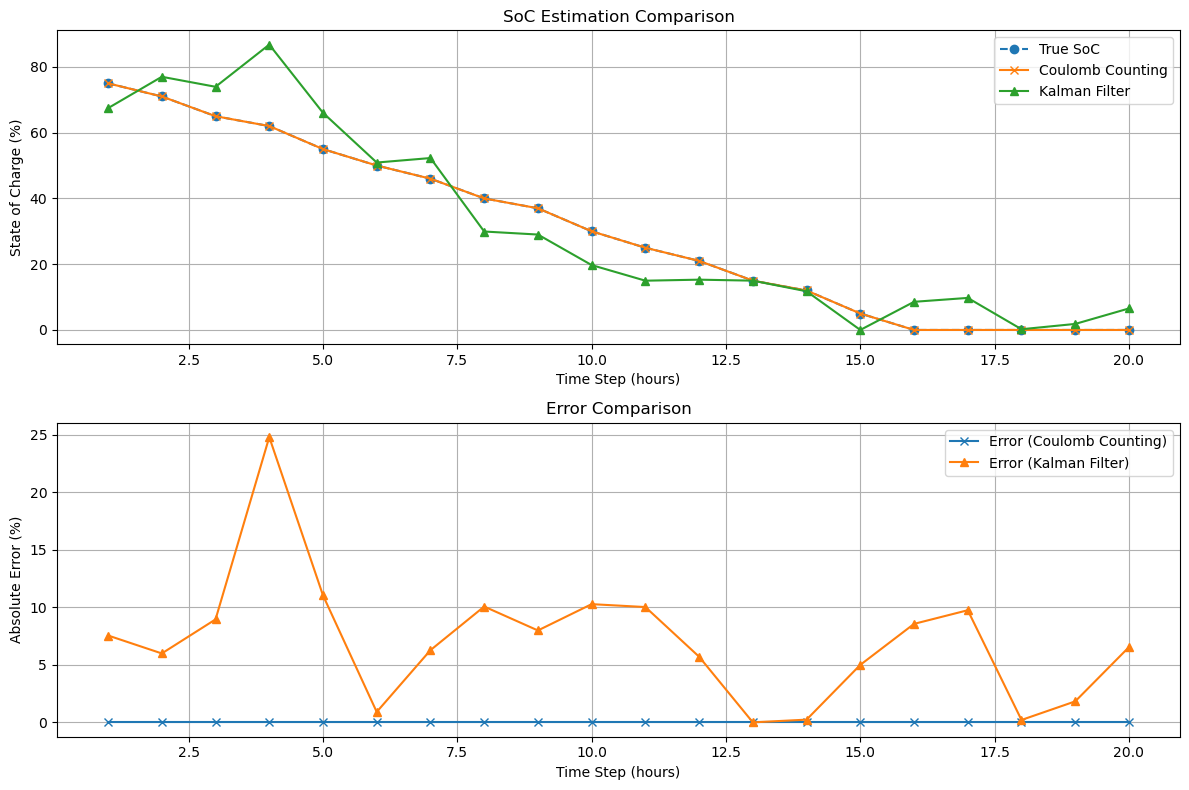

In [10]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.10  # Estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Nonlinear OCV model: OCV = 3.6 + 0.4 * SoC - 0.1 * SoC^2
        return 3.6 + 0.4 * soc - 0.1 * soc**2

    def predict(self, current, dt):
        # State prediction (Coulomb counting)
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))  # Clamp SoC
        # Update error covariance
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        # Measurement prediction
        v_pred = self.ocv(self.soc) - current * self.r_int
        # Innovation (measurement residual)
        y = voltage_measured - v_pred
        # Innovation covariance
        d_ocv_d_soc = 0.4 - 0.2 * self.soc  # Derivative of OCV w.r.t. SoC
        S = self.P * d_ocv_d_soc**2 + self.R
        # Kalman gain
        K = self.P * d_ocv_d_soc / S
        # Update state
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        # Update error covariance
        self.P = (1 - K * d_ocv_d_soc) * self.P


# Simulation and Visualization
def simulate_and_visualize():
    # Initialize Kalman Filter
    kf = KalmanFilterSoC(
        soc_initial=0.8,       # Initial SoC = 80%
        capacity=100,          # Battery capacity = 100 Ah
        r_int=0.05,            # Internal resistance = 0.05 Ohms
        process_noise=5e-3,    # Process noise covariance (higher uncertainty)
        measurement_noise=1e-2 # Measurement noise covariance (noisy measurements)
    )

    # Simulation parameters
    current_profile = [5, 4, 6, 3, 7, 5, 4, 6, 3, 7, 5, 4, 6, 3, 7, 5, 4, 6, 3, 7]  # Varying current
    dt = 1      # Time step (1 hour)
    true_soc = 0.8  # True SoC starts at 80%

    # Lists to store results for plotting
    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []
    coulomb_counting_socs = []  # Pure Coulomb counting without updates

    # Simulate over 20 hours
    soc_coulomb = 0.8  # Initialize Coulomb counting SoC
    for t in range(20):
        current = current_profile[t]  # Varying current

        # True SoC decreases due to current draw
        true_soc -= (current * dt) / kf.capacity
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate measured voltage based on true SoC
        ocv_true = kf.ocv(true_soc)  # True OCV from the model
        voltage_measured = ocv_true - current * kf.r_int  # Add IR drop
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))  # Add measurement noise

        # Coulomb counting (pure prediction)
        soc_coulomb -= (current * dt) / kf.capacity
        soc_coulomb = max(0, min(1, soc_coulomb))

        # Prediction step
        kf.predict(current=current, dt=dt)
        predicted_soc = kf.soc

        # Update step
        kf.update(voltage_measured=voltage_measured, current=current)
        updated_soc = kf.soc

        # Store results for plotting
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)  # Convert to percentage
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)
        coulomb_counting_socs.append(soc_coulomb * 100)

    # Calculate error metrics
    mae_coulomb = np.mean(np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")
    print(f"Mean Absolute Error (Kalman Filter): {mae_updated:.2f}%")

    # Plot results
    plt.figure(figsize=(12, 8))

    # Plot SoC estimates
    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC", linestyle="--", marker="o")
    plt.plot(time_steps, coulomb_counting_socs, label="Coulomb Counting", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Kalman Filter", linestyle="-", marker="^")
    plt.title("SoC Estimation Comparison")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    # Plot errors
    plt.subplot(2, 1, 2)
    error_coulomb = np.abs(np.array(coulomb_counting_socs) - np.array(true_socs))
    error_kf = np.abs(np.array(updated_socs) - np.array(true_socs))
    plt.plot(time_steps, error_coulomb, label="Error (Coulomb Counting)", linestyle="-", marker="x")
    plt.plot(time_steps, error_kf, label="Error (Kalman Filter)", linestyle="-", marker="^")
    plt.title("Error Comparison")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run the simulation and visualization
simulate_and_visualize()

Mean Absolute Error (Coulomb Counting): 0.29%
Mean Absolute Error (Kalman Filter): 0.54%


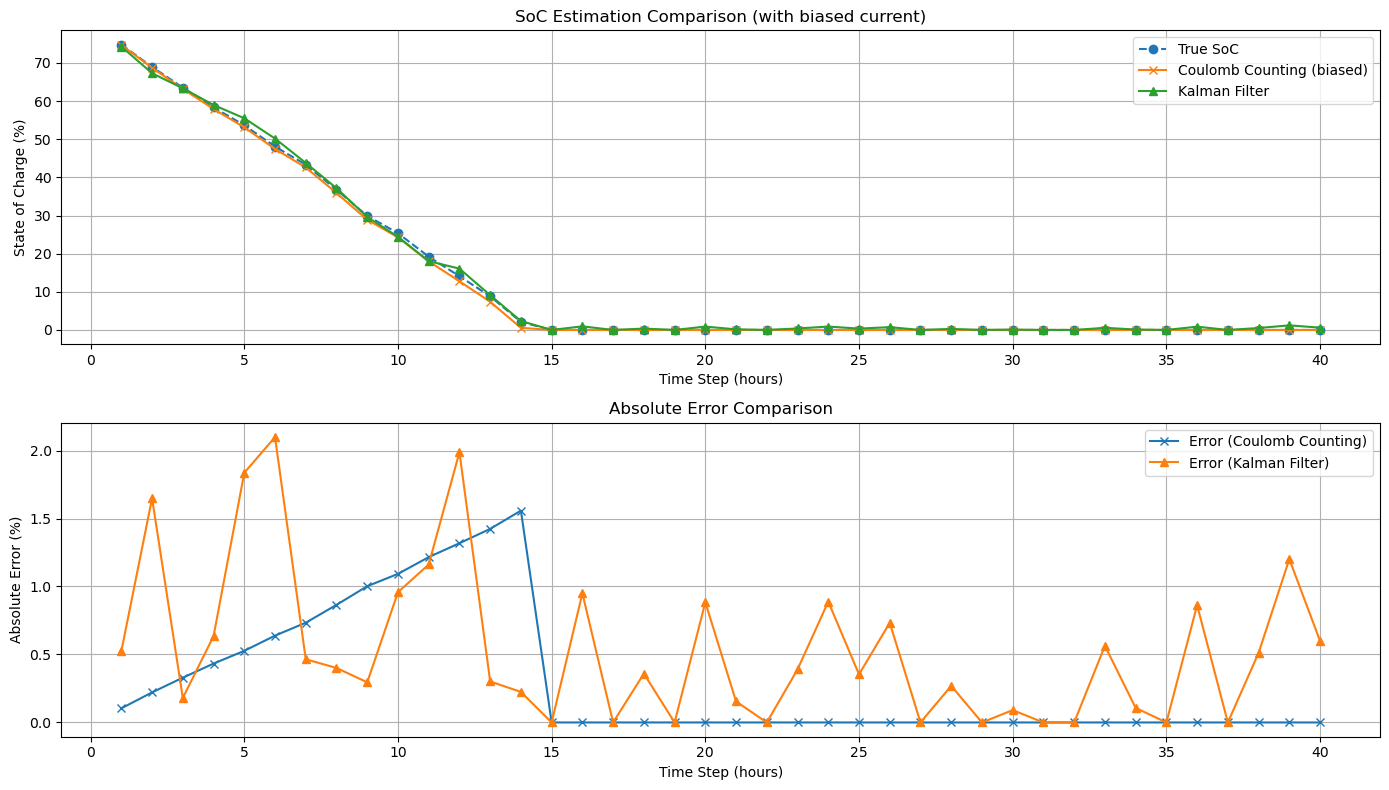

In [16]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.10  # Estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Modified: Steeper OCV curve!
        return 3.0 + 1.0 * soc - 0.2 * soc**2

    def predict(self, current, dt):
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        v_pred = self.ocv(self.soc) - current * self.r_int
        y = voltage_measured - v_pred
        d_ocv_d_soc = 1.0 - 0.4 * self.soc  # Derivative of OCV w.r.t. SoC
        S = self.P * d_ocv_d_soc**2 + self.R
        K = self.P * d_ocv_d_soc / S
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        self.P = (1 - K * d_ocv_d_soc) * self.P


def simulate_and_visualize():
    kf = KalmanFilterSoC(
        soc_initial=0.8,
        capacity=100,          # 100 Ah
        r_int=0.05,            # Internal resistance
        process_noise=5e-4,    # Lower process noise
        measurement_noise=1e-4 # Lower measurement noise
    )

    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=40)  # Random currents between 3A and 7A
    dt = 1  # Time step (1 hour)
    true_soc = 0.8  # Start at 80%

    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []
    coulomb_counting_socs = []

    soc_coulomb = 0.8

    current_bias = 1.02  # 2% bias in current measurement

    for t in range(len(current_profile)):
        true_current = current_profile[t]
        measured_current = true_current * current_bias  # Bias added!

        # Update true SoC
        true_soc -= (true_current * dt) / kf.capacity
        true_soc = max(0, min(1, true_soc))

        # Simulate voltage measurement
        ocv_true = kf.ocv(true_soc)
        voltage_measured = ocv_true - true_current * kf.r_int
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))  # Small noise

        # Coulomb Counting (biased)
        soc_coulomb -= (measured_current * dt) / kf.capacity
        soc_coulomb = max(0, min(1, soc_coulomb))

        # Kalman prediction and update
        kf.predict(current=measured_current, dt=dt)
        predicted_soc = kf.soc
        kf.update(voltage_measured=voltage_measured, current=measured_current)
        updated_soc = kf.soc

        # Save
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)
        coulomb_counting_socs.append(soc_coulomb * 100)

    # Calculate error metrics
    mae_coulomb = np.mean(np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")
    print(f"Mean Absolute Error (Kalman Filter): {mae_updated:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC", linestyle="--", marker="o")
    plt.plot(time_steps, coulomb_counting_socs, label="Coulomb Counting (biased)", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Kalman Filter", linestyle="-", marker="^")
    plt.title("SoC Estimation Comparison (with biased current)")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_coulomb = np.abs(np.array(coulomb_counting_socs) - np.array(true_socs))
    error_kf = np.abs(np.array(updated_socs) - np.array(true_socs))
    plt.plot(time_steps, error_coulomb, label="Error (Coulomb Counting)", linestyle="-", marker="x")
    plt.plot(time_steps, error_kf, label="Error (Kalman Filter)", linestyle="-", marker="^")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run
simulate_and_visualize()


Mean Absolute Error (Coulomb Counting): 0.33%
Mean Absolute Error (EKF): 0.65%


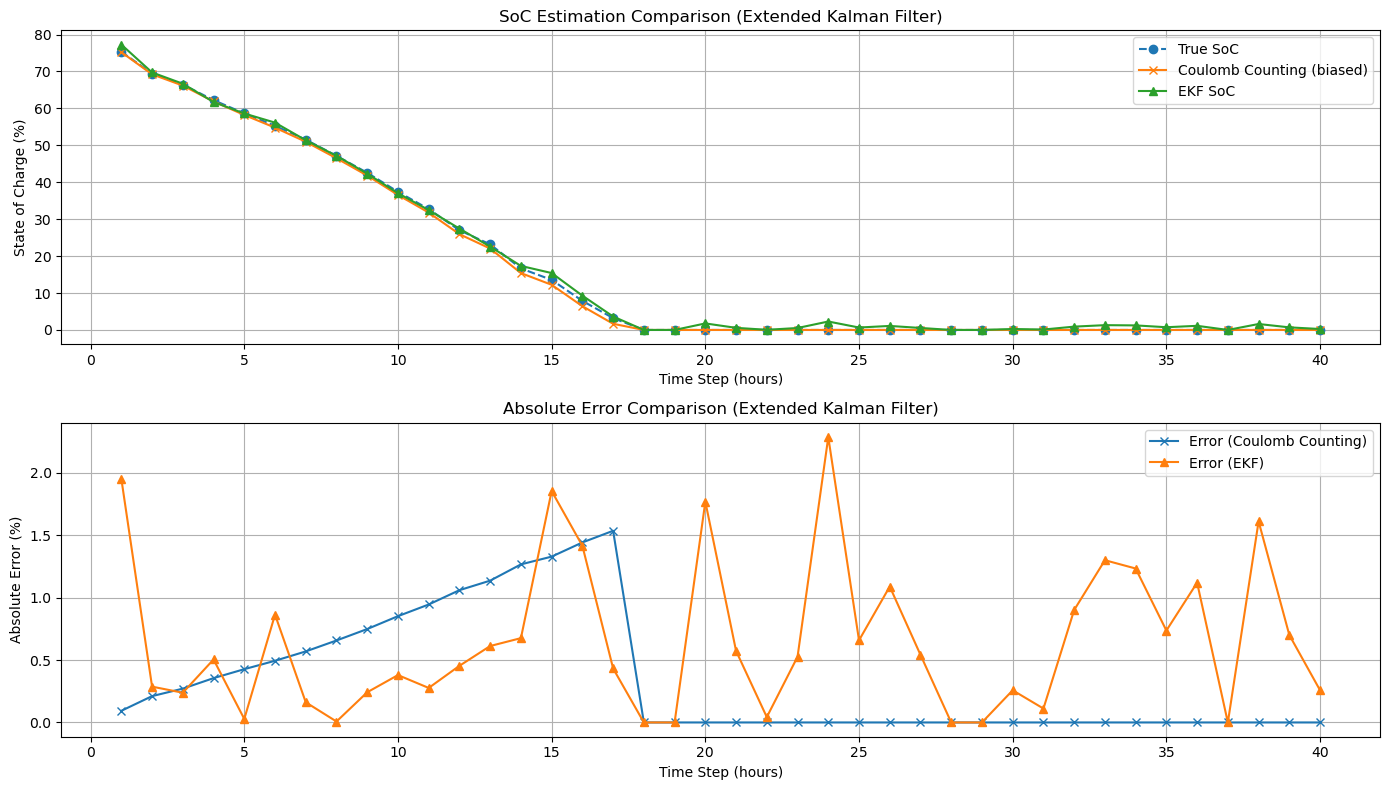

In [17]:
import numpy as np
import matplotlib.pyplot as plt

class ExtendedKalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial
        self.capacity = capacity
        self.r_int = r_int
        self.P = 0.10
        self.Q = process_noise
        self.R = measurement_noise

    def ocv(self, soc):
        # Nonlinear OCV model
        return 3.0 + 1.0 * soc - 0.2 * soc**2

    def d_ocv_d_soc(self, soc):
        # Derivative of OCV w.r.t. SoC
        return 1.0 - 0.4 * soc

    def predict(self, current, dt):
        # State prediction (Coulomb counting)
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))
        self.P = self.P + self.Q  # Increase uncertainty slightly

    def update(self, voltage_measured, current):
        # Measurement prediction
        v_pred = self.ocv(self.soc) - current * self.r_int

        # Jacobian of measurement function
        H = self.d_ocv_d_soc(self.soc)

        # Innovation
        y = voltage_measured - v_pred

        # Innovation covariance
        S = self.P * H**2 + self.R

        # Kalman gain
        K = self.P * H / S

        # Update state estimate
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))

        # Update error covariance
        self.P = (1 - K * H) * self.P


def simulate_and_visualize_ekf():
    ekf = ExtendedKalmanFilterSoC(
        soc_initial=0.8,
        capacity=100,          # 100 Ah
        r_int=0.05,            # Internal resistance
        process_noise=5e-4,    # Small process noise
        measurement_noise=1e-4 # Small measurement noise
    )

    # Simulation parameters
    np.random.seed(1)  # Different seed for different random currents
    current_profile = np.random.uniform(3, 7, size=40)  # Random currents
    dt = 1
    true_soc = 0.8

    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []
    coulomb_counting_socs = []

    soc_coulomb = 0.8
    current_bias = 1.02  # 2% bias again

    for t in range(len(current_profile)):
        true_current = current_profile[t]
        measured_current = true_current * current_bias

        # True SoC update
        true_soc -= (true_current * dt) / ekf.capacity
        true_soc = max(0, min(1, true_soc))

        # Measured voltage
        ocv_true = ekf.ocv(true_soc)
        voltage_measured = ocv_true - true_current * ekf.r_int
        voltage_measured += np.random.normal(0, np.sqrt(ekf.R))

        # Coulomb Counting
        soc_coulomb -= (measured_current * dt) / ekf.capacity
        soc_coulomb = max(0, min(1, soc_coulomb))

        # EKF prediction and update
        ekf.predict(current=measured_current, dt=dt)
        predicted_soc = ekf.soc
        ekf.update(voltage_measured=voltage_measured, current=measured_current)
        updated_soc = ekf.soc

        # Save
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)
        coulomb_counting_socs.append(soc_coulomb * 100)

    # Error metrics
    mae_coulomb = np.mean(np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")
    print(f"Mean Absolute Error (EKF): {mae_updated:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC", linestyle="--", marker="o")
    plt.plot(time_steps, coulomb_counting_socs, label="Coulomb Counting (biased)", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="EKF SoC", linestyle="-", marker="^")
    plt.title("SoC Estimation Comparison (Extended Kalman Filter)")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_coulomb = np.abs(np.array(coulomb_counting_socs) - np.array(true_socs))
    error_ekf = np.abs(np.array(updated_socs) - np.array(true_socs))
    plt.plot(time_steps, error_coulomb, label="Error (Coulomb Counting)", linestyle="-", marker="x")
    plt.plot(time_steps, error_ekf, label="Error (EKF)", linestyle="-", marker="^")
    plt.title("Absolute Error Comparison (Extended Kalman Filter)")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run EKF simulation
simulate_and_visualize_ekf()


Mean Absolute Error (Coulomb Counting): 0.42%
Mean Absolute Error (Kalman Filter): 1.40%


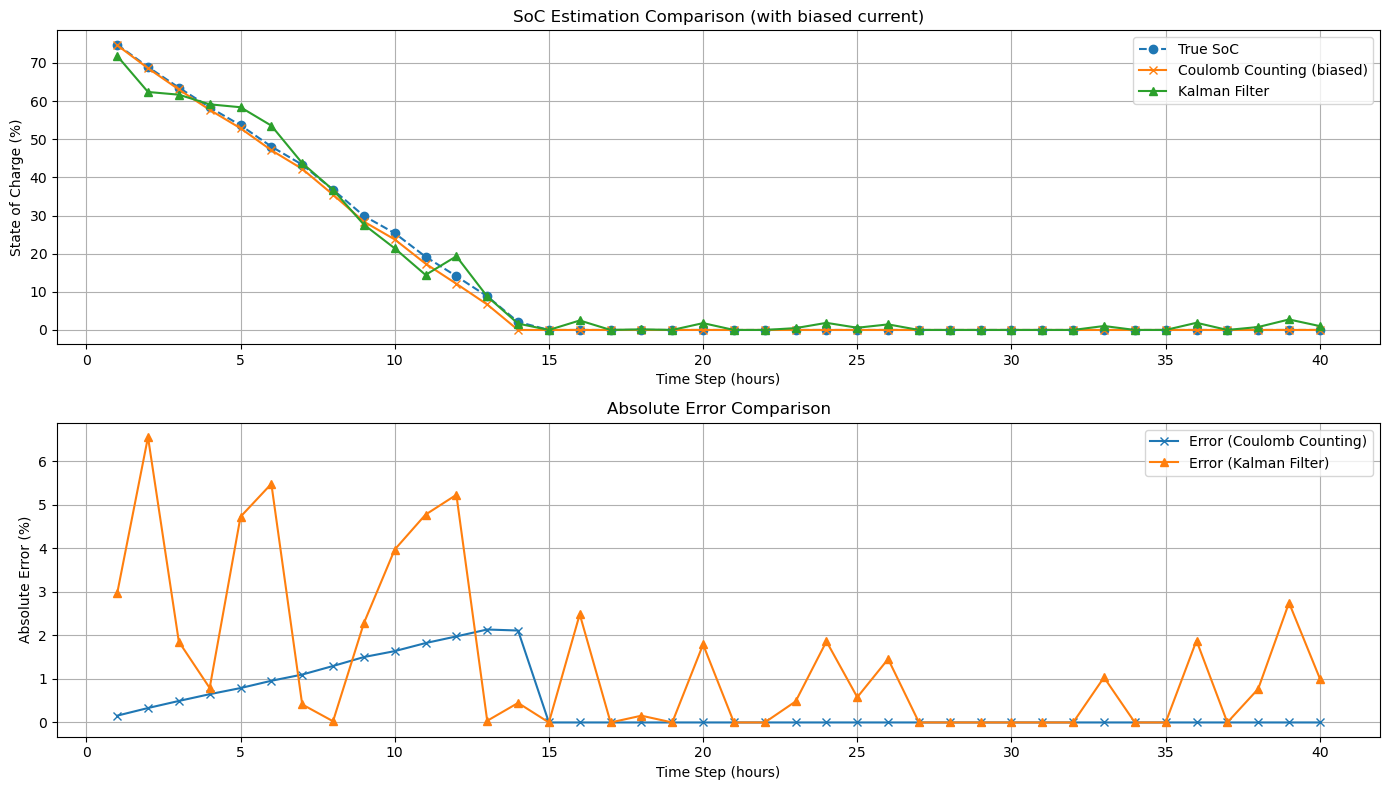

In [23]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.15  # Estimate error covariance
        
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Modified: Steeper OCV curve!
        return 3.0 + 1.0 * soc - 0.2 * soc**2

    def predict(self, current, dt):
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        v_pred = self.ocv(self.soc) - current * self.r_int
        y = voltage_measured - v_pred
        d_ocv_d_soc = 1.0 - 0.4 * self.soc  # Derivative of OCV w.r.t. SoC
        S = self.P * d_ocv_d_soc**2 + self.R
        K = self.P * d_ocv_d_soc / S
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        self.P = (1 - K * d_ocv_d_soc) * self.P


def simulate_and_visualize():
    kf = KalmanFilterSoC(
        soc_initial=0.8,
        capacity=100,          # 100 Ah
        r_int=0.05,            # Internal resistance
        process_noise=1e-2,    # Lower process noise
        measurement_noise=5e-4 # Slightly higher measurement noise for Kalman to make it work harder
    )

    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=40)  # Random currents between 3A and 7A
    dt = 1  # Time step (1 hour)
    true_soc = 0.8  # Start at 80%

    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []
    coulomb_counting_socs = []

    soc_coulomb = 0.8

    # Larger current bias to simulate drift in Coulomb Counting
    current_bias = 1.10  # 10% bias in current measurement
    current_bias = 1.03  # 10% bias in current measurement

    for t in range(len(current_profile)):
        true_current = current_profile[t]
        measured_current = true_current * current_bias  # Bias added!

        # Update true SoC
        true_soc -= (true_current * dt) / kf.capacity
        true_soc = max(0, min(1, true_soc))

        # Simulate voltage measurement
        ocv_true = kf.ocv(true_soc)
        voltage_measured = ocv_true - true_current * kf.r_int
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))  # Small noise

        # Coulomb Counting (biased)
        soc_coulomb -= (measured_current * dt) / kf.capacity
        soc_coulomb = max(0, min(1, soc_coulomb))

        # Kalman prediction and update
        kf.predict(current=measured_current, dt=dt)
        predicted_soc = kf.soc
        kf.update(voltage_measured=voltage_measured, current=measured_current)
        updated_soc = kf.soc

        # Save
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)
        coulomb_counting_socs.append(soc_coulomb * 100)

    # Calculate error metrics
    mae_coulomb = np.mean(np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")
    print(f"Mean Absolute Error (Kalman Filter): {mae_updated:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC", linestyle="--", marker="o")
    plt.plot(time_steps, coulomb_counting_socs, label="Coulomb Counting (biased)", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Kalman Filter", linestyle="-", marker="^")
    plt.title("SoC Estimation Comparison (with biased current)")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_coulomb = np.abs(np.array(coulomb_counting_socs) - np.array(true_socs))
    error_kf = np.abs(np.array(updated_socs) - np.array(true_socs))
    plt.plot(time_steps, error_coulomb, label="Error (Coulomb Counting)", linestyle="-", marker="x")
    plt.plot(time_steps, error_kf, label="Error (Kalman Filter)", linestyle="-", marker="^")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run
simulate_and_visualize()



Mean Absolute Error (Coulomb Counting): 0.67%
Mean Absolute Error (Kalman Filter): 1.50%


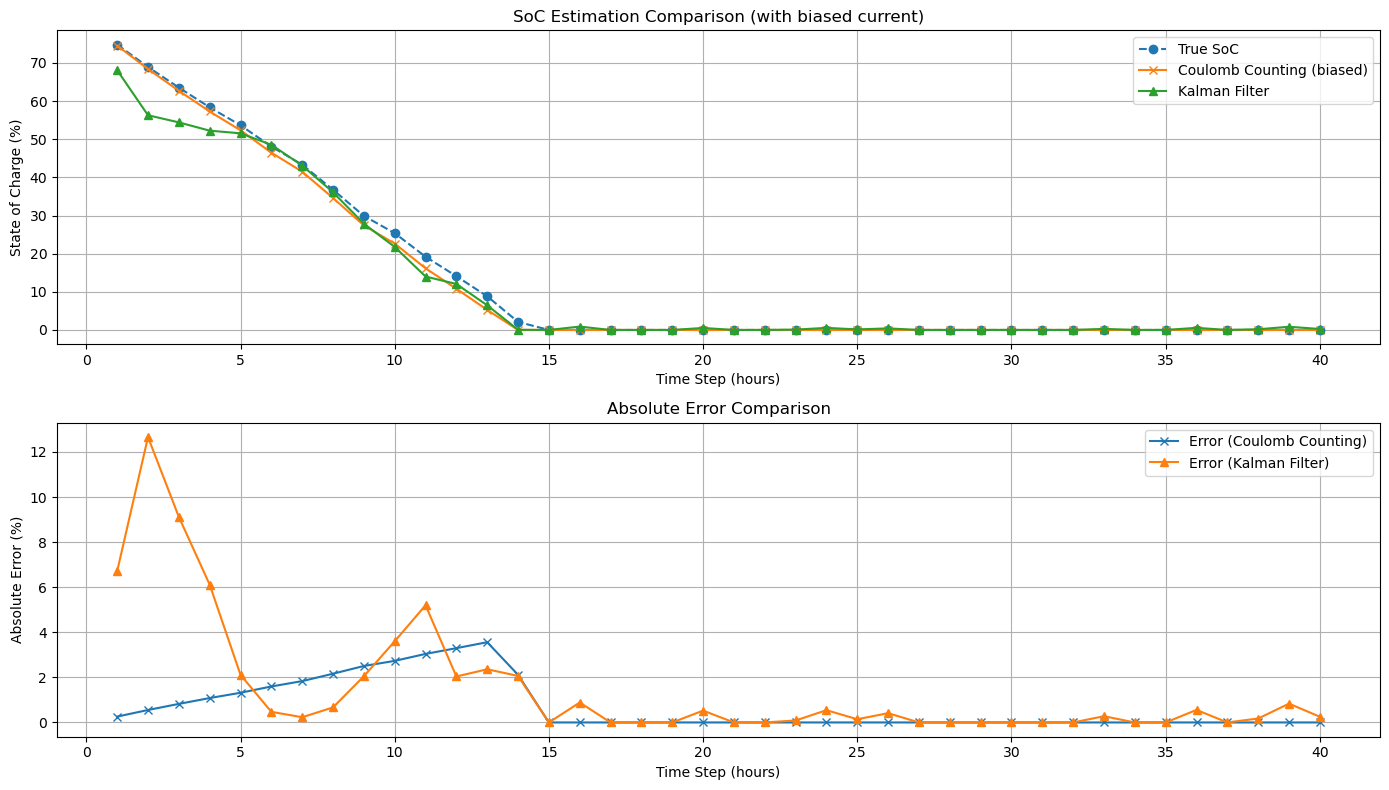

In [26]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.050  # Increased initial estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Modified: Steeper and more non-linear OCV curve!
        return 3.0 + 1.5 * soc - 0.5 * soc**2 + 0.1 * soc**3

    def predict(self, current, dt):
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        v_pred = self.ocv(self.soc) - current * self.r_int
        y = voltage_measured - v_pred
        # More accurate derivative of OCV w.r.t. SoC
        d_ocv_d_soc = 1.5 - 1.0 * self.soc + 0.3 * self.soc**2
        S = self.P * d_ocv_d_soc**2 + self.R
        K = self.P * d_ocv_d_soc / S
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        self.P = (1 - K * d_ocv_d_soc) * self.P


def simulate_and_visualize():
    kf = KalmanFilterSoC(
        soc_initial=0.8,
        capacity=100,         # 100 Ah
        r_int=0.05,           # Internal resistance
        process_noise=1e-4,     # Significantly lower process noise
        measurement_noise=1e-2 # Higher measurement noise
    )

    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=40)  # Random currents between 3A and 7A
    dt = 1  # Time step (1 hour)
    true_soc = 0.8  # Start at 80%

    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []
    coulomb_counting_socs = []

    soc_coulomb = 0.8

    # Larger current bias to simulate drift in Coulomb Counting
    current_bias = 1.05  # 5% bias in current measurement

    for t in range(len(current_profile)):
        true_current = current_profile[t]
        measured_current = true_current * current_bias  # Bias added!

        # Update true SoC
        true_soc -= (true_current * dt) / kf.capacity
        true_soc = max(0, min(1, true_soc))

        # Simulate voltage measurement with more significant noise
        ocv_true = kf.ocv(true_soc)
        voltage_measured = ocv_true - true_current * kf.r_int
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))

        # Coulomb Counting (biased)
        soc_coulomb -= (measured_current * dt) / kf.capacity
        soc_coulomb = max(0, min(1, soc_coulomb))

        # Kalman prediction and update
        kf.predict(current=measured_current, dt=dt)
        predicted_soc = kf.soc
        kf.update(voltage_measured=voltage_measured, current=measured_current)
        updated_soc = kf.soc

        # Save
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)
        coulomb_counting_socs.append(soc_coulomb * 100)

    # Calculate error metrics
    mae_coulomb = np.mean(np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")
    print(f"Mean Absolute Error (Kalman Filter): {mae_updated:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC", linestyle="--", marker="o")
    plt.plot(time_steps, coulomb_counting_socs, label="Coulomb Counting (biased)", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Kalman Filter", linestyle="-", marker="^")
    plt.title("SoC Estimation Comparison (with biased current)")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_coulomb = np.abs(np.array(coulomb_counting_socs) - np.array(true_socs))
    error_kf = np.abs(np.array(updated_socs) - np.array(true_socs))
    plt.plot(time_steps, error_coulomb, label="Error (Coulomb Counting)", linestyle="-", marker="x")
    plt.plot(time_steps, error_kf, label="Error (Kalman Filter)", linestyle="-", marker="^")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (hours)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run
simulate_and_visualize()

Mean Absolute Error (Coulomb Counting): 0.81%
Mean Absolute Error (Kalman Filter): 1.03%


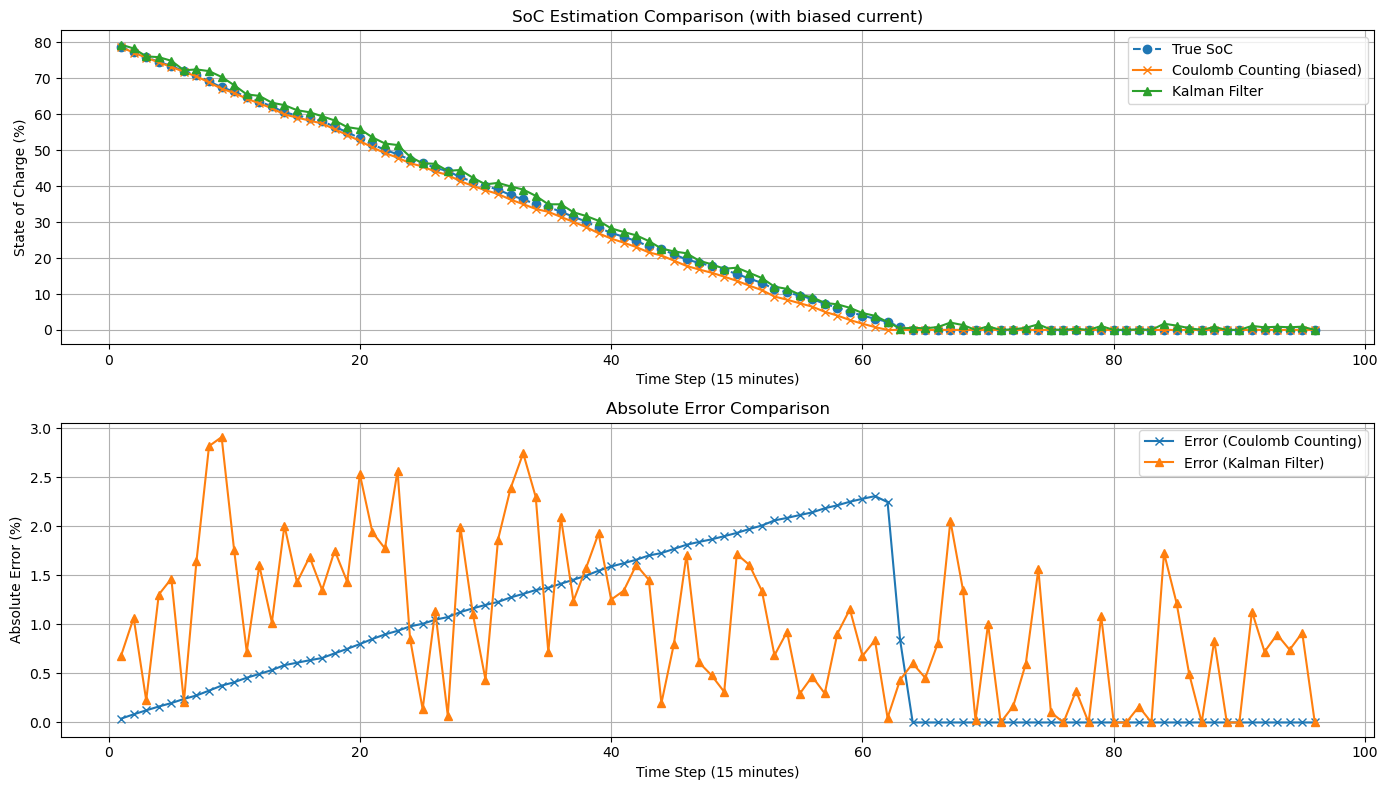

In [30]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.10  # Estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Modified: Steeper OCV curve!
        return 3.0 + 1.0 * soc - 0.2 * soc**2

    def predict(self, current, dt):
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        v_pred = self.ocv(self.soc) - current * self.r_int
        y = voltage_measured - v_pred
        d_ocv_d_soc = 1.0 - 0.4 * self.soc  # Derivative of OCV w.r.t. SoC
        S = self.P * d_ocv_d_soc**2 + self.R
        K = self.P * d_ocv_d_soc / S
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        self.P = (1 - K * d_ocv_d_soc) * self.P


def simulate_and_visualize():
    kf = KalmanFilterSoC(
        soc_initial=0.8,
        capacity=100,          # 100 Ah
        r_int=0.05,            # Internal resistance
        process_noise=1e-4,    # Increased process noise for better adaptability
        measurement_noise=1e-4 # Slightly increased measurement noise for better adaptation
    )

    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=96)  # 96 samples (every 15 minutes)
    dt = 0.25  # Time step (15 minutes)
    true_soc = 0.8  # Start at 80%

    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []
    coulomb_counting_socs = []

    soc_coulomb = 0.8

    # Current bias to simulate realistic drift
    current_bias = 1.03  # 3% bias in current measurement

    for t in range(len(current_profile)):
        true_current = current_profile[t]
        measured_current = true_current * current_bias  # Bias added!

        # Update true SoC
        true_soc -= (true_current * dt) / kf.capacity
        true_soc = max(0, min(1, true_soc))

        # Simulate voltage measurement
        ocv_true = kf.ocv(true_soc)
        voltage_measured = ocv_true - true_current * kf.r_int
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))  # Small noise

        # Coulomb Counting (biased)
        soc_coulomb -= (measured_current * dt) / kf.capacity
        soc_coulomb = max(0, min(1, soc_coulomb))

        # Kalman prediction and update
        kf.predict(current=measured_current, dt=dt)
        predicted_soc = kf.soc
        kf.update(voltage_measured=voltage_measured, current=measured_current)
        updated_soc = kf.soc

        # Save
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)
        coulomb_counting_socs.append(soc_coulomb * 100)

    # Calculate error metrics
    mae_coulomb = np.mean(np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")
    print(f"Mean Absolute Error (Kalman Filter): {mae_updated:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC", linestyle="--", marker="o")
    plt.plot(time_steps, coulomb_counting_socs, label="Coulomb Counting (biased)", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Kalman Filter", linestyle="-", marker="^")
    plt.title("SoC Estimation Comparison (with biased current)")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_coulomb = np.abs(np.array(coulomb_counting_socs) - np.array(true_socs))
    error_kf = np.abs(np.array(updated_socs) - np.array(true_socs))
    plt.plot(time_steps, error_coulomb, label="Error (Coulomb Counting)", linestyle="-", marker="x")
    plt.plot(time_steps, error_kf, label="Error (Kalman Filter)", linestyle="-", marker="^")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run
simulate_and_visualize()


Mean Absolute Error (Coulomb Counting): 1.73%
Mean Absolute Error (Kalman Filter): 0.91%


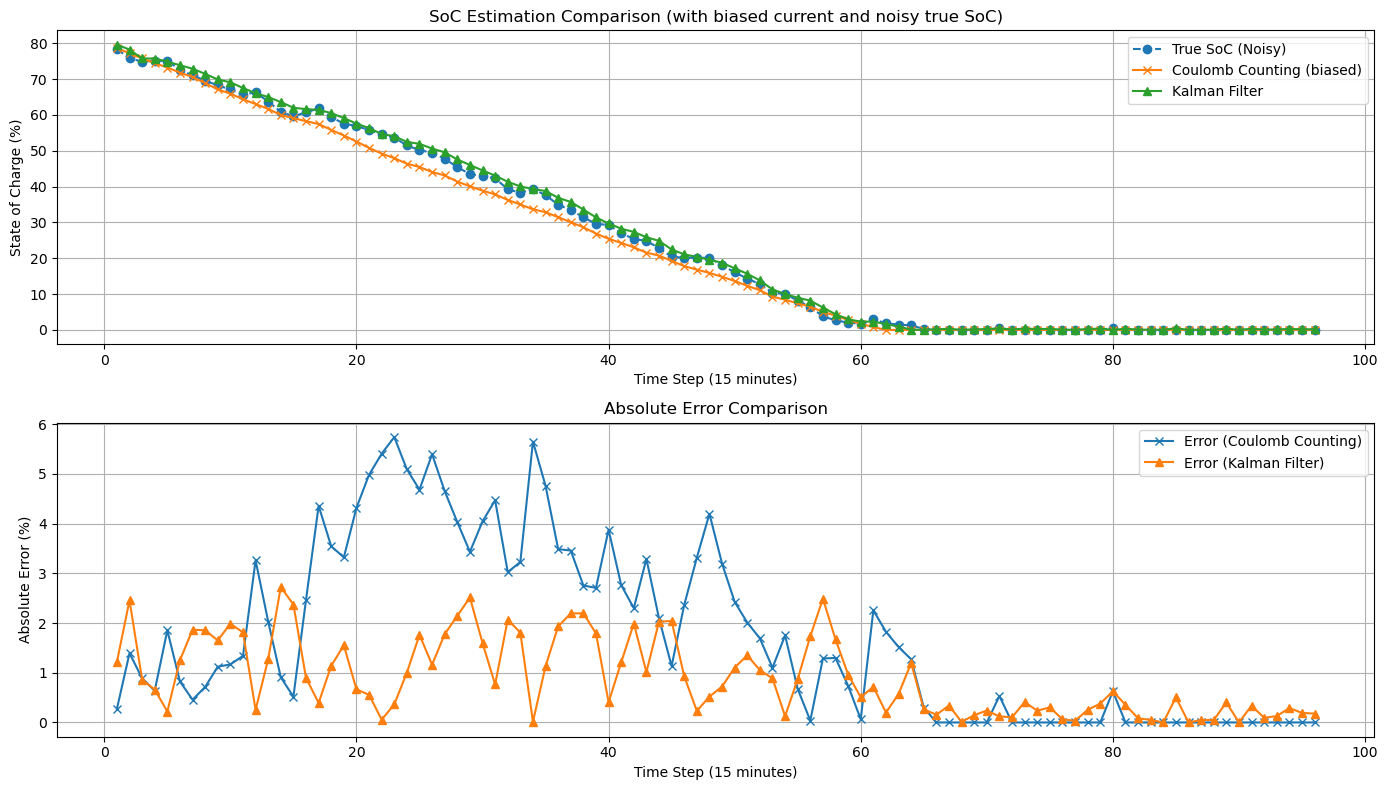

In [42]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.10  # Estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Modified: Steeper OCV curve!
        return 3.0 + 1.0 * soc - 0.2 * soc**2
        # return 3.0 + 0.5 * soc

    def predict(self, current, dt):
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        v_pred = self.ocv(self.soc) - current * self.r_int
        y = voltage_measured - v_pred
        d_ocv_d_soc = 1.0 - 0.4 * self.soc  # Derivative of OCV w.r.t. SoC
        S = self.P * d_ocv_d_soc**2 + self.R
        K = self.P * d_ocv_d_soc / S
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        self.P = (1 - K * d_ocv_d_soc) * self.P


def simulate_and_visualize():
    kf = KalmanFilterSoC(
        soc_initial=0.8,
        capacity=100,          # 100 Ah
        r_int=0.05,            # Internal resistance
        process_noise=1e-5,    # Increased process noise for better adaptability
        measurement_noise=1e-4 # Slightly increased measurement noise for better adaptation
    )

    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=96)  # 96 samples (every 15 minutes)
    dt = 0.25  # Time step (15 minutes)
    true_soc = 0.8  # Start at 80%

    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []
    coulomb_counting_socs = []

    soc_coulomb = 0.8

    # Current bias to simulate realistic drift
    current_bias = 1.03  # 3% bias in current measurement

    for t in range(len(current_profile)):
        true_current = current_profile[t]
        measured_current = true_current * current_bias  # Bias added!

        # Update true SoC
        true_soc -= (true_current * dt) / kf.capacity
        
        # Add noise to true SoC
        true_soc += np.random.normal(0, 0.01)  # Small noise added to true SoC
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate voltage measurement
        ocv_true = kf.ocv(true_soc)
        voltage_measured = ocv_true - true_current * kf.r_int
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))  # Small noise

        # Coulomb Counting (biased)
        soc_coulomb -= (measured_current * dt) / kf.capacity
        soc_coulomb = max(0, min(1, soc_coulomb))

        # Kalman prediction and update
        kf.predict(current=measured_current, dt=dt)
        predicted_soc = kf.soc
        kf.update(voltage_measured=voltage_measured, current=measured_current)
        updated_soc = kf.soc

        # Save
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)
        coulomb_counting_socs.append(soc_coulomb * 100)

    # Calculate error metrics
    mae_coulomb = np.mean(np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")
    print(f"Mean Absolute Error (Kalman Filter): {mae_updated:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC (Noisy)", linestyle="--", marker="o")
    plt.plot(time_steps, coulomb_counting_socs, label="Coulomb Counting (biased)", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Kalman Filter", linestyle="-", marker="^")
    plt.title("SoC Estimation Comparison (with biased current and noisy true SoC)")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_coulomb = np.abs(np.array(coulomb_counting_socs) - np.array(true_socs))
    error_kf = np.abs(np.array(updated_socs) - np.array(true_socs))
    plt.plot(time_steps, error_coulomb, label="Error (Coulomb Counting)", linestyle="-", marker="x")
    plt.plot(time_steps, error_kf, label="Error (Kalman Filter)", linestyle="-", marker="^")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run
simulate_and_visualize()